 # David Bowie II (buscando canciones similares)
 
 La última entrada en mi blog la dediqué a [David Bowie[(http://www.jmgaguilera.com/an%C3%A1lisis/2016/01/24/david-bowie.html).
 
 Hoy quiero ampliar aquella entrada profundizando en las relaciones que existen entre sus canciones. Para ello voy a basarme únicamente en sus letras. Y utilizaré herramientas de
 análisis de texto no estructurado para determinar la _cercanía_ de una canción a otras. 
 


In [51]:
from __future__ import print_function
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

songs = pd.read_csv("bowie_songs.csv", encoding="utf-8")

## Antecedentes

Recuerdo que teníamos las letras de 254 canciones. Como en el artículo anterior, lo primero que tenemos que hacer es convertir las letras a términos, descartando, en la medida de lo posibles, las diferencias entre plurales y singulares, así como formas verbales.

## Términos

En primer lugar, vamos a crear una lista de palabras que se van a descartar de cada canción. Son palabras generales, artículos, etc.


In [52]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append(u'chorus')
stopwords.append(u"'m")
stopwords.append(u"'s")
stopwords.append(u"'ll")
stopwords.append(u"n't")
stopwords.append(u"'d")
stopwords.append(u"ca")
stopwords.append(u"wo")
stopwords.append(u'oh')
stopwords.append(u"yeah")
stopwords.append(u"x2")

Cargamos la clase que se encargará de realizar el *stemming*

In [53]:

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
    

Realizamos el tokenizado quedándonos con las palabras más frecuentes (al menos con un peso de 0.05 de frecuencia.


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=0.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,1))

tfidf_matrix = tfidf_vectorizer.fit_transform(songs['lyrics']) 



Ahora generamos una matriz de distancia entre las canciones a partir de la matriz de frecuencias de términos y documentos. Con esta matriz de distancias clusterizamos las canciones usando el método de _ward_ que va uniendo las más cercanas entre sí. para formar un árbol que permite ver los posibles clusteres en que se agrupan.

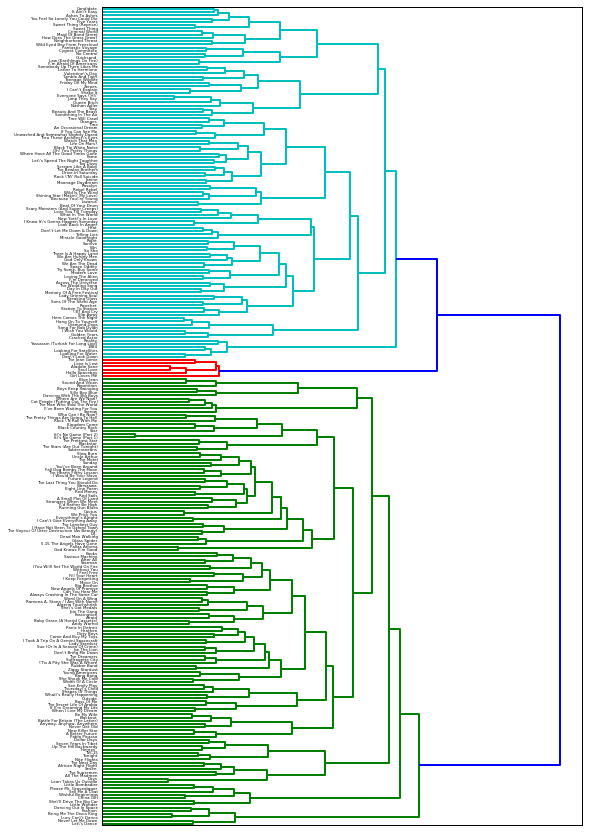

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import ward, dendrogram, cut_tree

%matplotlib inline

mpl.rcParams['lines.linewidth'] = 2

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(8.27, 11.69)) # A4
ax = dendrogram(linkage_matrix, orientation="right", leaf_font_size=4, labels=list(songs['song']));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.svg', dpi=200) #save figure as ward_clusters


Como hay demasiadas canciones, cuesta distinguirlas en un árbol tan denso.

A continuación vamos a asumir que son ocho los grupos que vamos a formar y los vamos a ver de uno en uno.

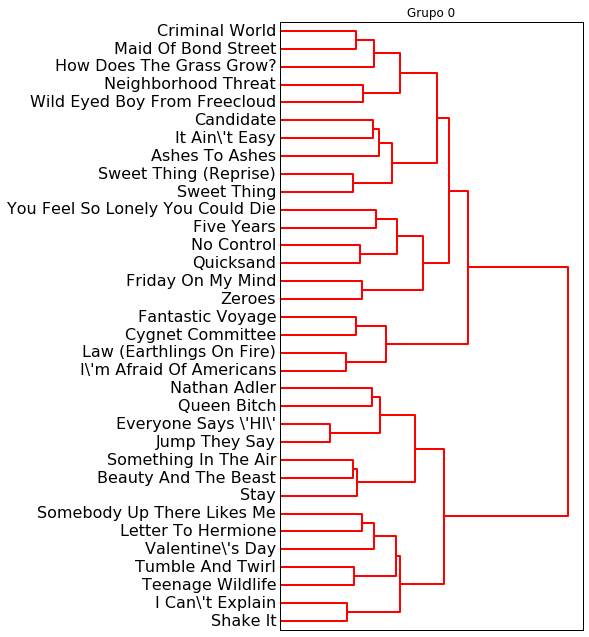

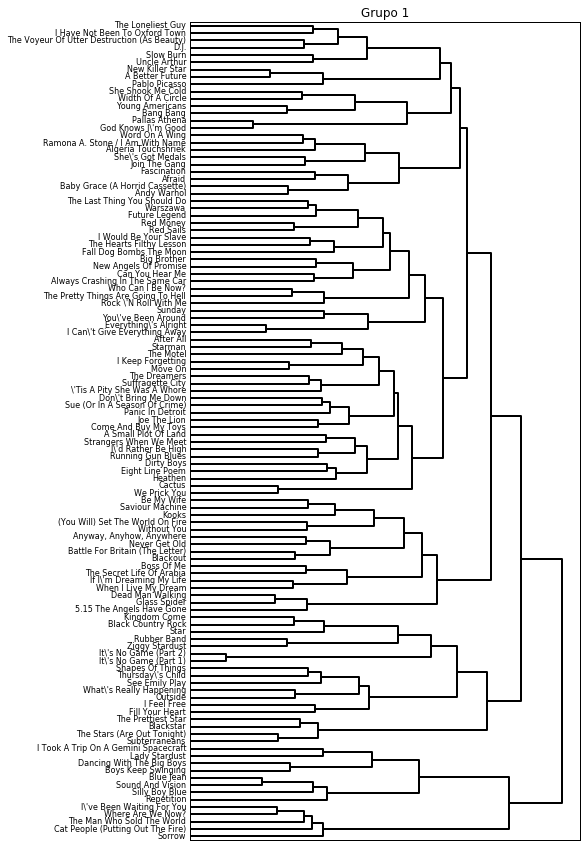

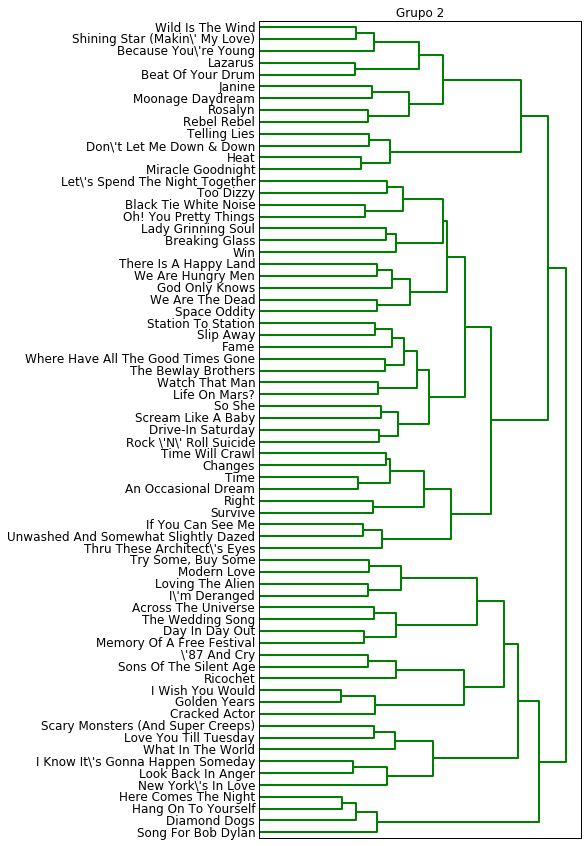

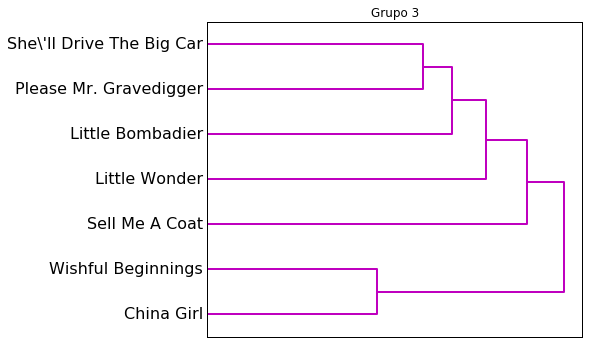

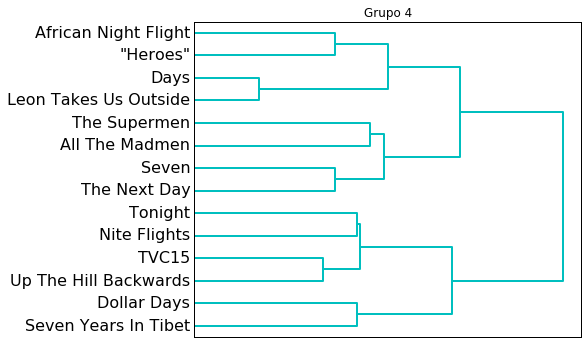

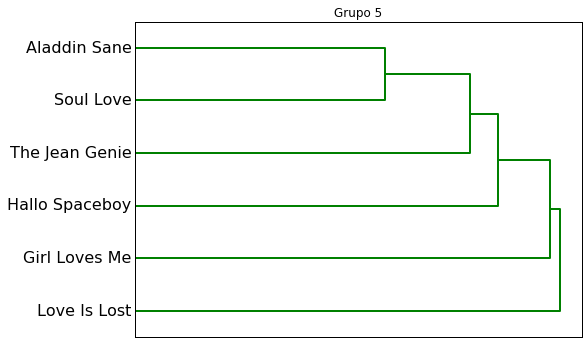

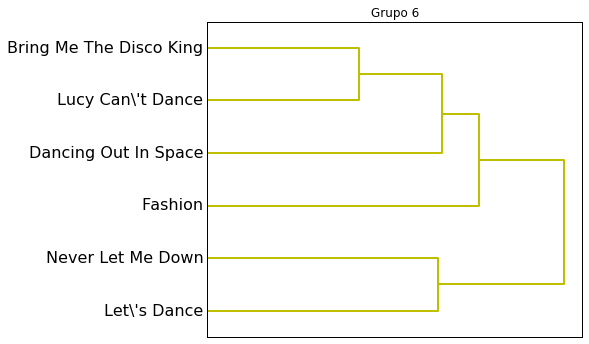

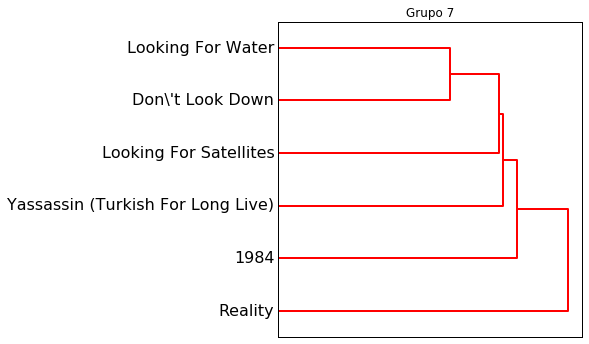

In [56]:

# se pasa el número de clusters que se quieren
def sub_tree(num_cluster, l_m):
    """
    Recibe el número de clusters y la linkage matrix original
    Retorna un vector de linkage_matrix, uno por cada cluster
    """
    cutree = cut_tree(l_m, num_cluster).flatten()
    colores = ['r','k','g','m','c','g','y','r']
    font_size = [16,8,12,16,16,16,16,16]
    song_cluster = []
    diagram_height = [0.75,1,1,0.4,0.4,0.4,0.4,0.4]
    for i in range(num_cluster):
        s = songs[cutree.flatten() == i]
        cluster_dist = dist[s.index][:,s.index]
        l_m = ward(cluster_dist)
        fig, ax_cl = plt.subplots(figsize=(8.27,11.69*diagram_height[i])) # set size
        ax_cl = dendrogram(l_m, orientation="right", leaf_font_size=font_size[i], 
                           link_color_func=lambda x: colores[i], 
                            labels=list(songs.song[s.index]));
                            
        song_cluster.append(s.index)                            
                            
        plt.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        plt.tight_layout() #show plot with tight layout
        plt.title("Grupo %s" % i)
        plt.savefig('ward_clusters_'+str(i)+'.svg', dpi=200) #save figure as ward_clusters
    return song_cluster
        
        
song_cluster = sub_tree(8, linkage_matrix)


Por último, puede ser interesante conocer cuáles son los términos más habituales en cada uno de los grupos, así es posible determinar cuál es el _patrón_ que ha servido para generar cada grupo. Lo que, incluso, puede dar lugar a la generación automática de _etiquetas_ para cada canción.

In [57]:
print("Palabras más repetidas en cada grupo:")
print()
for i in range(8):
    print("Grupo %d:" % i)
    lista = tfidf_matrix[song_cluster[i]]
    ll = lista.toarray()
    ll = np.sum(ll, axis=0)    
    df_term = pd.DataFrame({"term":tfidf_vectorizer.get_feature_names(), 
                            "freq":ll})
    df_term['word'] = list(vocab_frame[vocab_frame.index == i]['words'][0] for i in df_term['term'])
    df_term = df_term.sort("freq", ascending=False)
    print(df_term.head())
    print()
    print()
        
print()
print()

Palabras más repetidas en cada grupo:

Grupo 0:


/home/jmgaguilera/dato-env/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


         freq   term    word
170  5.365048    say    says
224  4.782514   want    want
76   3.478711    got     got
18   2.581732    boy     boy
200  2.482339  thing  things


Grupo 1:
         freq  term  word
122  4.380216   man   man
196  4.167142  take  take
18   4.055294   boy   boy
116  4.042343  long  long
67   4.020220   get   get


Grupo 2:
         freq  term  word
119  7.463742  love  love
111  6.080673  like  like
32   5.357936  come  come
204  4.716788  time  time
8    4.685532  babi  baby


Grupo 3:
         freq    term    word
113  3.624713   littl  little
68   1.478087    girl   girls
56   0.751800    feel    feel
7    0.749316    away    away
233  0.705218  wonder  wonder


Grupo 4:
         freq  term     word
38   3.690027   day      day
144  3.295195   one      one
141  2.358883  noth  nothing
41   1.519879   die    dying
109  1.143182  life     life


Grupo 5:
         freq  term   word
119  3.861197  love   love
68   0.995499  girl  girls
138  0.991495   new    n